# Clusters as Knowledge Areas of Annotators

In [3]:
# import required packages
import sys
sys.path.append("../..")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from annotlib import ClusterBasedAnnot

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

A popular approach to simulate annotators is to use clustering methods. 
By using clustering methods, we can emulate areas of knowledge. 
The assumption is that the knowledge of an annotator is not constant for a whole classification problem, but there are areas where the annotator has a wider knowledge compared to areas of sparse knowledge. 

As the samples lie in a feature space, we can model the area of knowledge as an area in the feature space.

The simulation of annotators by means of clustering is implemented by the class [ClusterBasedAnnot](../annotlib.cluster_based.rst). 
To create such annotators, you have to provide the samples `X`, their corresponding true class labels `y_true` and the cluster labels `y_cluster`.

In this section, we introduce the following simulation options:

- class labels as clustering,
- clustering algorithms to find clustering,
- and feature space as a single cluster.

The code below generates a two-dimensional (`n_features=2`) artificial data set with `n_samples=500` samples and `n_classes=4` classes.

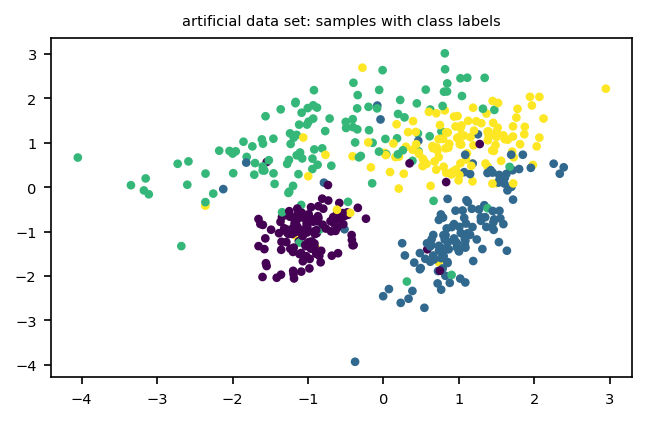

In [4]:
X, y_true =  make_classification(n_samples=500, n_features=2, 
                                 n_informative=2, n_redundant=0, 
                                 n_repeated=0, n_classes=4, 
                                 n_clusters_per_class=1, 
                                 flip_y=0.1, random_state=4)
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, s=10)
plt.title('artificial data set: samples with class labels', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

## 1. Class Labels as Clustering
If you do not provide any cluster labels `y_cluster`, the true class labels `y_true` are assumed to be a representive clustering. 
As a result the class labels and cluster labels are equivalent `y_cluster = y_true` and define the knowledge areas of the simulated annotators. 

To simulate annotators on this dataset, we create an instance of the [ClusterBasedAnnot](../annotlib.cluster_based.rst) class by providing the samples `X` with the true labels `y_true` as input.

In [5]:
# simulate annotators where the clusters are defined by the class labels
clust_annot_cls = ClusterBasedAnnot(X=X, y_true=y_true, random_state=42)

The above simulated annotators have knowledge areas defined by the class label distribution. 
As a result, there are four knowledge areas respectively clusters. 

In the default setting, the number of annotators is equal to the number of defined clusters. 
Correspondingly, there are four simulated annotators in our example.
☝🏽An important aspect is the simulation of the labelling performances of the annotators on the different clusters.

By default, each annotator is assumed to be an expert on a single cluster.
Since we have four clusters and four annotators, each cluster has only one annotator as expert.

Being an expert means that an annotator has a higher probability for providing the correct class label for a sample than in the clusters of low expertise.

Let the number of clusters be $K$ (`n_clusters`) and the number of annotators be $A$ (`n_annotators`). 
For the case $K=A$, an annotator $a_i$ is expert on cluster $c_i$ with $i \in \{0,\dots,A-1\}$, the probability of providing the correct class label $y^{\text{true}}_\mathbf{x}$ for sample $\mathbf{x} \in c_i$ is defined by 

$$p(y^{\text{true}}_\mathbf{x} \mid \mathbf{x}, a_i, c_i) = U(0.8, 1.0)$$

where $U(a,b)$ means that a value is uniformly drawn from the interval $[0.8, 1.0]$.
In contrast for the clusters of low expertise, the default probability for providing a correct class label is defined by

$$p(y^{\text{true}}_\mathbf{x} \mid \mathbf{x}, a_i, c_j) = U\left(\frac{1}{C}, \text{min}(\frac{1}{C}+0.1,1)\right),$$

where $j=0,\dots,A-1$, $j\neq i$ and $C$ denotes the number of classes (`n_classes`).

These properties apply only for the default settings.
The actual labelling accuracies per cluster are exemplary plotted for annotator $a_0$ below.

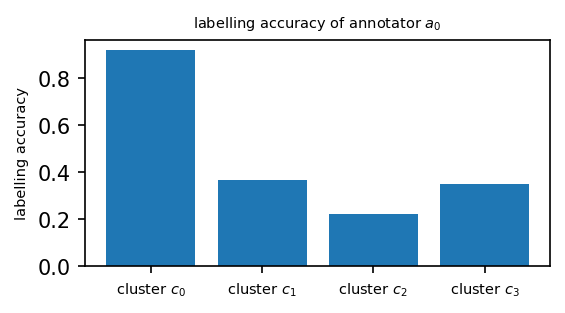

In [6]:
acc_cluster = clust_annot_cls.labelling_performance_per_cluster(accuracy_score)
x = np.arange(len(np.unique(clust_annot_cls.y_cluster_)))
plt.figure(figsize=(4, 2), dpi=150)
plt.bar(x, acc_cluster[0])
plt.xticks(x, ('cluster $c_0$', 'cluster $c_1$', 'cluster $c_2$', 
           'cluster $c_3$'), fontsize=7)
plt.ylabel('labelling accuracy', fontsize=7)
plt.title('labelling accuracy of annotator $a_0$', 
          fontsize=7)
plt.show()

The above figure matches the description of the default behaviour.
We can see that the accuracy of annotator $a_0$ is high in cluster $c_0$, whereas the labelling accuracy on the remaining clusters is comparable to randomly guessing of class labels.

You can also manually define properties of the annotators.
This may be interesting when you want to evaluate the performance of a developed method coping with multiple uncertain annotators. 

Let's see how the ranges of uniform distributions for correct class labels on the clusters can be defined manually. For the default setting, we observe the following ranges:

In [7]:
print('ranges of uniform distributions for correct' 
      +' class labels on the clusters:')
for a in range(clust_annot_cls.n_annotators()):
    print('annotator a_' + str(a) + ':\n' 
          + str(clust_annot_cls.cluster_labelling_acc_[a]))

ranges of uniform distributions for correct class labels on the clusters:
annotator a_0:
[[0.8  1.  ]
 [0.25 0.35]
 [0.25 0.35]
 [0.25 0.35]]
annotator a_1:
[[0.25 0.35]
 [0.8  1.  ]
 [0.25 0.35]
 [0.25 0.35]]
annotator a_2:
[[0.25 0.35]
 [0.25 0.35]
 [0.8  1.  ]
 [0.25 0.35]]
annotator a_3:
[[0.25 0.35]
 [0.25 0.35]
 [0.25 0.35]
 [0.8  1.  ]]


The attribute `cluster_labelling_acc_` is an array with the shape `(n_annotators, n_clusters, 2)` and can be defined by means of the parameter `cluster_labelling_acc`.
This parameter may be either a `str` or array-like.

By default, `cluster_labelling_acc='one_hot'` is valid, which indicates that each annotator is expert on one cluster.

Another option is `cluster_labelling_acc='equidistant'` and is explained in one of the following examples. 

The entry `cluster_labelling_acc_[i, j , 0]` indicates the lower limit of the uniform distribution for correct class labels of annotator $a_i$ on cluster $c_j$. Analogous, the entry `cluster_labelling_acc_[i, j ,1]` represents the upper limit.

The sampled probabilities for correct class labels are also the confidence scores of the annotators.
An illustration of the annotators $a_0$ and $a_1$ simulated with default values on the predefined data set is given in the following plots. 
The confidence scores correspond to the size of the crosses and dots.

The confidence scores correspond to the size of the crosses and dots.


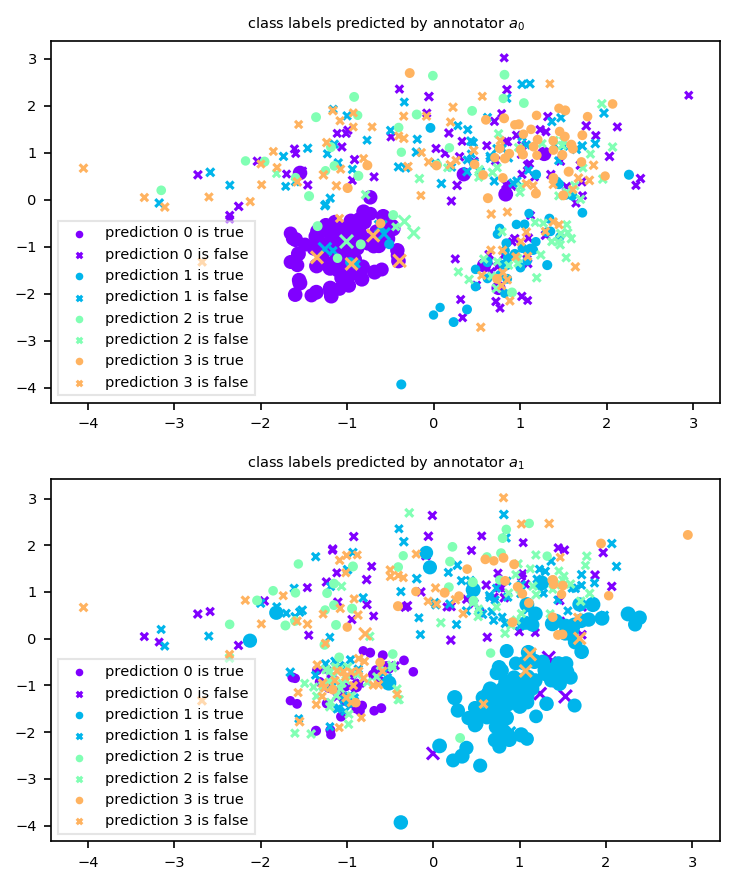

In [9]:
clust_annot_cls.plot_class_labels(X=X, y_true=y_true, annotator_ids=[0, 1], 
                                  plot_confidences=True)
print('The confidence scores correspond to the size of the crosses and dots.')
plt.tight_layout()
plt.show()

☝🏽To sum up, by using the true class labels `y_true` as proxy of a clustering and specifying the input parameter `cluster_labelling_acc`, annotators being experts on different classes can be simulated. 

## 2. Clustering Algorithms to Find Clustering
There are several algorithms available for perfoming clustering on a data set. The framework *scikit-learn* provides many clustering algorithms, e.g.

- `sklearn.cluster.KMeans`,
- `sklearn.cluster.DBSCAN`,
- `sklearn.cluster.AgglomerativeClustering`,
- `sklearn.cluster.bicluster.SpectralBiclusterin`,
- `sklearn.mixture.BayesianGaussianMixture`,
- and `sklearn.mixture.GaussianMixture`.

We examplary apply the `KMeans` algorithm being a very popular clustering algorithm. 
For this purpose, you have to specify the number of clusters. 
By doing so, you determine the number of different knowledge areas in the feature space with reference to the simulation of annotators.

We set `n_clusters = 3` as number of clusters. 
The clusters found by `KMeans` on the previously defined data set are given in the following:

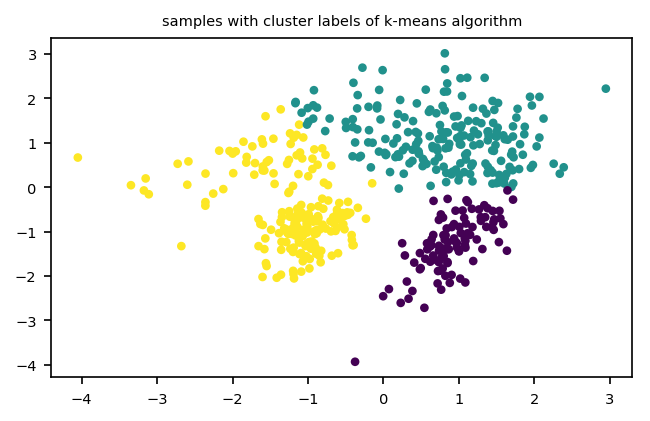

In [7]:
# standardize features of samples
X_z = StandardScaler().fit_transform(X)

# apply k-means algorithm
y_cluster_k_means = KMeans(n_clusters=3).fit_predict(X_z)

# plot found clustering
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], c=y_cluster_k_means, s=10)
plt.title('samples with cluster labels of k-means algorithm', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

The clusters are found on the standardised data set, so that the mean of each feature is 0 and the variance is 1.
The computed cluster labels `y_cluster` are used as input parameter to simulate two annotators, where the annotator $a_0$ is expert on two clusters and the annotator $a_1$ is expert on one cluster.

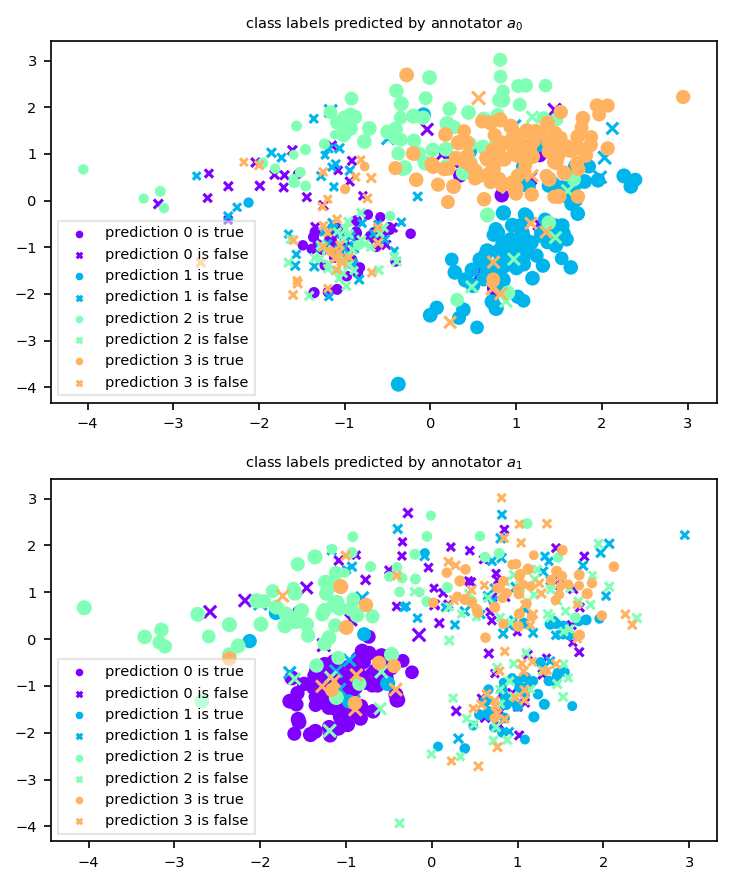

In [8]:
# define labelling accuracy ranges on four clusters for three annotators
clu_label_acc_km = np.array([[[0.8, 1], [0.8, 1], [0.3, 0.5]],
                                    [[0.3, 0.5], [0.3, 0.5], [0.8, 1]]])

# simulate annotators
cluster_annot_kmeans = ClusterBasedAnnot(X=X, y_true=y_true, 
                                         y_cluster=y_cluster_k_means, 
                                         n_annotators=2, 
                                         cluster_labelling_acc=clu_label_acc_km)

# scatter plots of annotators
cluster_annot_kmeans.plot_class_labels(X=X, y_true=y_true, 
                                       plot_confidences=True, 
                                       annotator_ids=[0, 1])
plt.tight_layout()
plt.show()

☝🏽The employment of different clustering allows to define almost arbitrarily knowledge areas and offers a huge flexibiility. 
However, the clusters should reflect the actual regions within a feature space.

## 3. Feature Space as a Single Cluster
Finally, you can simulate annotators whose knowledge does not depend on clusters.
Hence, their knowledge level is constant over the whole feature space. 
To emulate such a behaviour, you create a clustering array `y_cluster_const`, in which all samples in the feature space are assigned to the same cluster.

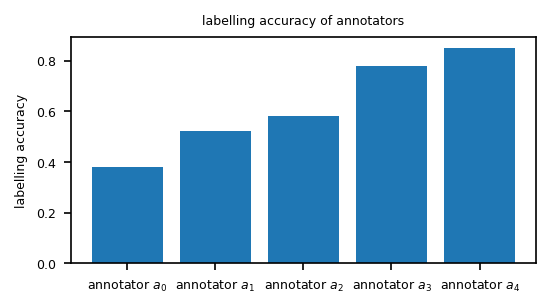

ranges of uniform distributions for correct class labels on the clusters:
annotator a_0: [[0.25 0.5 ]]
annotator a_1: [[0.375 0.625]]
annotator a_2: [[0.5  0.75]]
annotator a_3: [[0.625 0.875]]
annotator a_4: [[0.75 1.  ]]


In [9]:
y_cluster_const = np.zeros(len(X), dtype=int)
cluster_annot_const = ClusterBasedAnnot(X=X, y_true=y_true, 
                                        y_cluster=y_cluster_const, 
                                        n_annotators=5, 
                                        cluster_labelling_acc='equidistant')

# plot labelling accuracies
cluster_annot_const.plot_labelling_accuracy(X=X, y_true=y_true, 
                                            figsize=(4, 2), fontsize=6)
plt.show()

# print predefined labelling accuracies
print('ranges of uniform distributions for correct class ' 
      + 'labels on the clusters:')
for a in range(cluster_annot_const.n_annotators()):
    print('annotator a_' + str(a) + ': ' 
          + str(cluster_annot_const.cluster_labelling_acc_[a]))

Five annotators are simulated whose labelling accuracy intervals are increasing with the index number of the annotator. 
☝🏽The input parameter `cluster_labelling_acc='equidistant'` means that the lower bounds of the labelling accuracy intervals between two annotators have always the same distance. 

In general, the interval of the correct labelling probability for annotator $a_i$ is computed by

$$d = \frac{1 - \frac{1}{C}}{A+1},$$

$$p(y^{(\text{true})}_\mathbf{x} \mid \mathbf{x}, a_i, c_j) \in U(\frac{1}{C}  + i \cdot d,  \frac{1}{C}  + 2 \cdot i \cdot d),$$

where $i=0,\dots,A-1$ and $j=0,\dots,K-1$ with $K$.

This procedure ensures that the intervals of the correct labelling probabilities are overlapping.